In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [6]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [7]:
data_ts = torch.load( os.path.join(other_file_dir, 'data_ts_all_as_is.pt'), weights_only=False )# [:,training_subject_start:training_subject_end,:,:]
print( data_ts.size() )

torch.Size([4, 837, 360, 1200])


In [8]:
data_ts_individual_mean = data_ts.mean( dim=(0,2,3) )
print( data_ts_individual_mean.size() )
data_ts_group_mean = data_ts_individual_mean.mean()
print( data_ts_group_mean.size() )
data_ts_diff_from_mean = torch.abs( (data_ts_individual_mean - data_ts_group_mean)/data_ts_group_mean )

torch.Size([837])
torch.Size([])


In [9]:
data_ts_individual_std = data_ts.std( dim=(0,2,3) )
print( data_ts_individual_std.size() )
data_ts_group_std = data_ts.std( dim=(0,1,2,3) )
print( data_ts_group_std.size() )
data_ts_diff_from_std = torch.abs( (data_ts_individual_std - data_ts_group_std)/data_ts_group_std )

torch.Size([837])
torch.Size([])


Text(0.5, 1.0, 'absolute difference between individual and group mean BOLD signal')

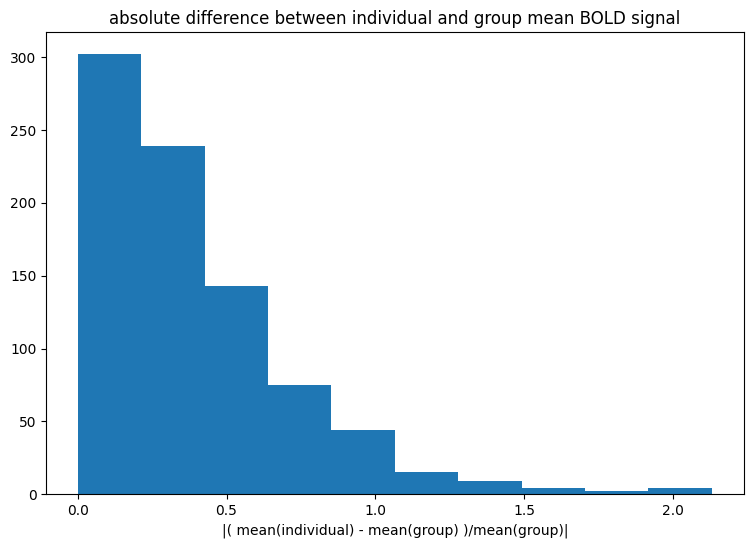

In [10]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.hist( depytorch(data_ts_diff_from_mean) )
axs.set_xlabel('|( mean(individual) - mean(group) )/mean(group)|')
axs.set_title('absolute difference between individual and group mean BOLD signal')

Text(0.5, 1.0, 'absolute difference between individual and group standard deviation of BOLD signal')

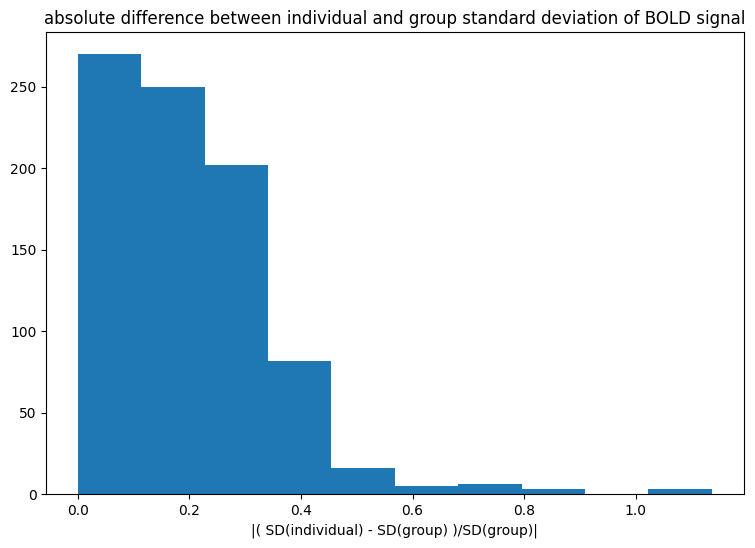

In [11]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.hist( depytorch(data_ts_diff_from_std) )
axs.set_xlabel('|( SD(individual) - SD(group) )/SD(group)|')
axs.set_title('absolute difference between individual and group standard deviation of BOLD signal')

In [12]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
data_string = f'thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
mean_state_binarized_file = os.path.join(file_dir, f'mean_state_{data_string}.pt')
mean_state_binarized = torch.load(mean_state_binarized_file, weights_only=False)
print( mean_state_binarized.size() )
mean_state_product_binarized_file = os.path.join(file_dir, f'mean_state_product_{data_string}.pt')
mean_state_product_binarized = torch.load(mean_state_product_binarized_file, weights_only=False)
print( mean_state_product_binarized.size() )

torch.Size([31, 360])
torch.Size([31, 360, 360])


In [13]:
fc_binarized = isingmodellight.get_fc(state_mean=mean_state_binarized, state_product_mean=mean_state_product_binarized, epsilon=0)
print( fc_binarized.size() )

torch.Size([31, 360, 360])


In [14]:
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)

In [15]:
selected_threshold = 1.0

In [16]:
threshold_index = get_closest_match(values=threshold, target=selected_threshold)
print(threshold[threshold_index])

tensor(1., device='cuda:0')


In [17]:
selected_group_mean_state = mean_state_binarized[threshold_index,:]
selected_group_mean_state_product = mean_state_product_binarized[threshold_index,:,:]
selected_fc = fc_binarized[threshold_index,:,:]

In [18]:
individual_data_string = f'all_mean_std_{selected_threshold:.3g}'

In [19]:
# for threshold=0
individual_param_string = f'{data_string}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000'

In [19]:
# for threshold=1
individual_param_string = f'{individual_data_string}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000'

In [20]:
mean_state_individual_file = os.path.join(file_dir, f'mean_state_{individual_data_string}.pt')
mean_state_individual = torch.load(mean_state_individual_file, weights_only=False)
print( mean_state_individual.size() )
mean_state_product_individual_file = os.path.join(file_dir, f'mean_state_product_{individual_data_string}.pt')
mean_state_product_individual = torch.load(mean_state_product_individual_file, weights_only=False)
print( mean_state_product_individual.size() )

torch.Size([4, 837, 360])
torch.Size([4, 837, 360, 360])


In [21]:
fc_individual = isingmodellight.get_fc( state_mean=mean_state_individual.mean(dim=0), state_product_mean=mean_state_product_individual.mean(dim=0), epsilon=0 )
print( fc_individual.size() )

torch.Size([837, 360, 360])


In [22]:
fc_rmse_from_group = isingmodellight.get_pairwise_rmse_ut( mat1=fc_individual.unsqueeze(dim=0), mat2=selected_fc.unsqueeze(dim=0).unsqueeze(dim=0) ).squeeze(dim=0)
print( fc_rmse_from_group.size() )

torch.Size([837])


Text(0.5, 1.0, 'RMSE between individual and group FC')

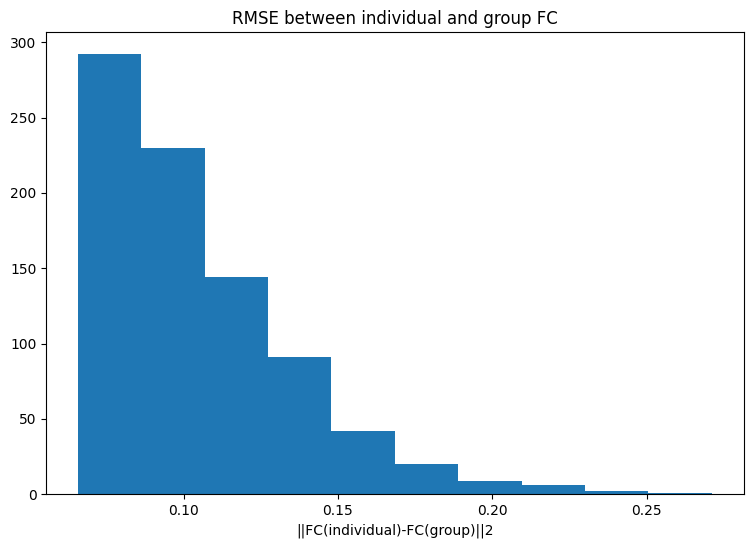

In [23]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.hist( depytorch(fc_rmse_from_group) )
axs.set_xlabel('||FC(individual)-FC(group)||2')
axs.set_title('RMSE between individual and group FC')

correlation between difference in binarized FC RMSE and difference in original mean 0.0176


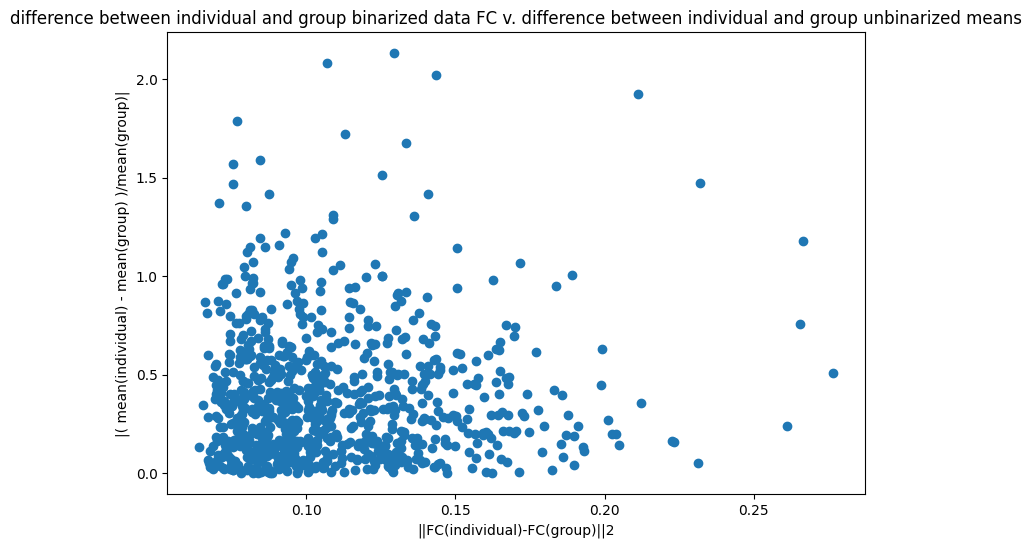

In [24]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.scatter( depytorch(fc_rmse_from_group), depytorch(data_ts_diff_from_mean) )
axs.set_xlabel('||FC(individual)-FC(group)||2')
axs.set_ylabel('|( mean(individual) - mean(group) )/mean(group)|')
axs.set_title('difference between individual and group binarized data FC v. difference between individual and group unbinarized means')
fc_diff_corr = isingmodellight.get_pairwise_correlation(mat1=fc_rmse_from_group, mat2=data_ts_diff_from_mean, epsilon=0, dim=0)
print(f'correlation between difference in binarized FC RMSE and difference in original mean {fc_diff_corr:.3g}')

correlation between difference in binarized FC RMSE and difference in original SD 0.382


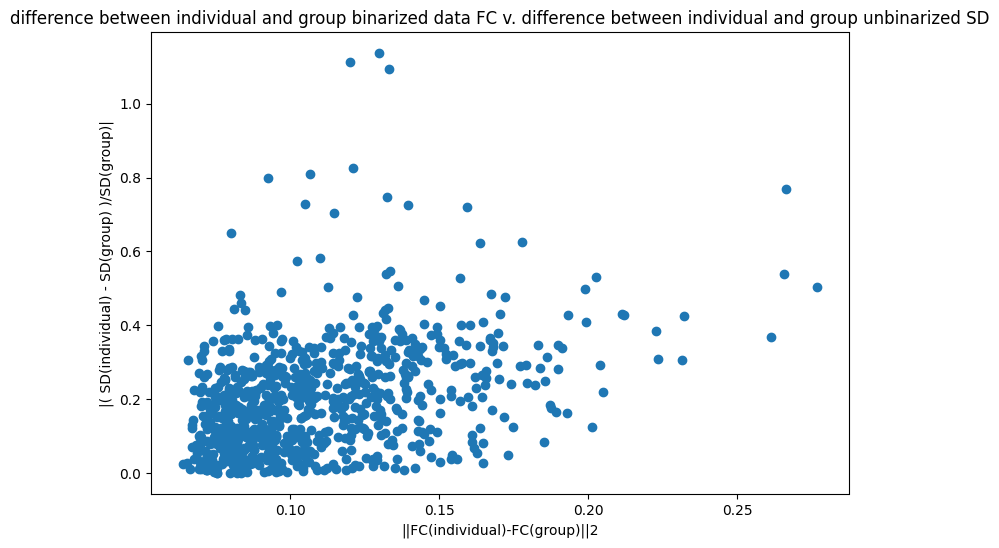

In [25]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.scatter( depytorch(fc_rmse_from_group), depytorch(data_ts_diff_from_std) )
axs.set_xlabel('||FC(individual)-FC(group)||2')
axs.set_ylabel('|( SD(individual) - SD(group) )/SD(group)|')
axs.set_title('difference between individual and group binarized data FC v. difference between individual and group unbinarized SD')
fc_std_diff_corr = isingmodellight.get_pairwise_correlation(mat1=fc_rmse_from_group, mat2=data_ts_diff_from_std, epsilon=0, dim=0)
print(f'correlation between difference in binarized FC RMSE and difference in original SD {fc_std_diff_corr:.3g}')

In [26]:
num_permutations = 1000000
permutation_corr = torch.zeros( size=(num_permutations,), dtype=fc_std_diff_corr.dtype, device=fc_std_diff_corr.device )
num_subjects = fc_rmse_from_group.numel()
for permutation_index in range(num_permutations):
    permutation = torch.randperm(n=num_subjects, dtype=int_type, device=fc_rmse_from_group.device)
    permutation_corr[permutation_index] = isingmodellight.get_pairwise_correlation(mat1=fc_rmse_from_group[permutation], mat2=data_ts_diff_from_std, epsilon=0, dim=0).abs()
critical_value = torch.quantile(input=permutation_corr, q=0.975, dim=0)
is_sig = fc_std_diff_corr.abs() >= critical_value
print(f'FC RMSE vs SD difference correlation {fc_std_diff_corr:.3g} vs critical value {critical_value:.3g}, |real| >= crit {is_sig}')

FC RMSE vs SD difference correlation 0.382 vs critical value 0.0774, |real| >= crit True


In [ ]:
data_z = data_ts
data_z -= data_ts_individual_mean.unsqueeze(dim=0).unsqueeze(dim=-1).unsqueeze(dim=-1)
data_z /= data_ts_individual_std.unsqueeze(dim=0).unsqueeze(dim=-1).unsqueeze(dim=-1)

In [29]:
data_z.pow_(3.0)
data_skewness_individual = data_z.mean( dim=(0,2,3) )
print( data_skewness_individual.size() )
data_skewness_group = data_z.mean( dim=(0,1,2,3) )
print( data_skewness_group.size() )
data_ts_diff_from_skewness = torch.abs( (data_skewness_individual - data_skewness_group)/data_skewness_group )

torch.Size([837])
torch.Size([])


correlation between difference in binarized FC RMSE and difference in original skewness 0.00385


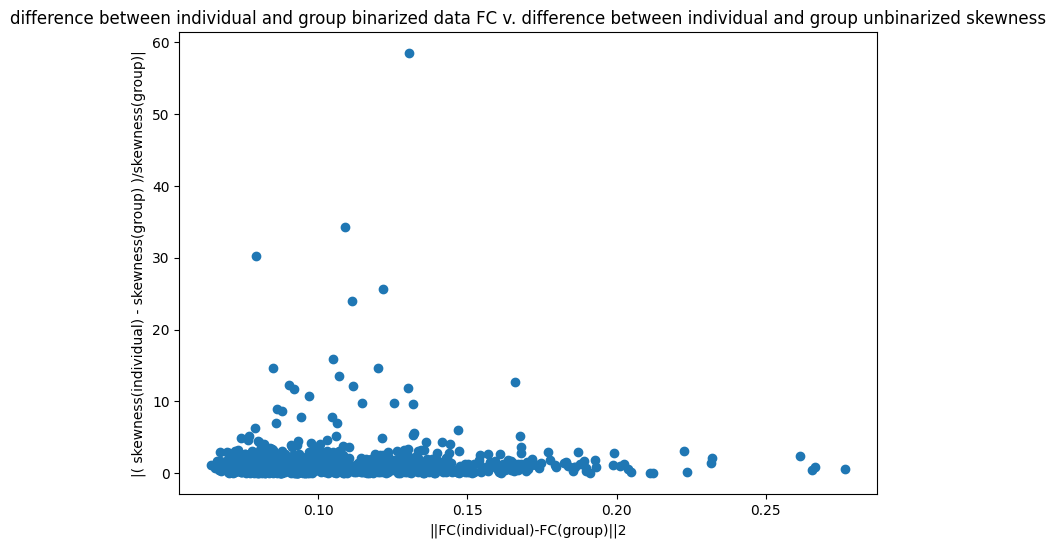

In [31]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.scatter( depytorch(fc_rmse_from_group), depytorch(data_ts_diff_from_skewness) )
axs.set_xlabel('||FC(individual)-FC(group)||2')
axs.set_ylabel('|( skewness(individual) - skewness(group) )/skewness(group)|')
axs.set_title('difference between individual and group binarized data FC v. difference between individual and group unbinarized skewness')
fc_std_diff_corr = isingmodellight.get_pairwise_correlation(mat1=fc_rmse_from_group, mat2=data_ts_diff_from_skewness, epsilon=0, dim=0)
print(f'correlation between difference in binarized FC RMSE and difference in original skewness {fc_std_diff_corr:.3g}')

In [36]:
data_z.pow_(4.0)
data_kurtosis_individual = data_z.mean( dim=(0,2,3) )
print( data_kurtosis_individual.size() )
data_kurtosis_group = data_z.mean( dim=(0,1,2,3) )
print( data_kurtosis_group.size() )
data_ts_diff_from_kurtosis = torch.abs( (data_kurtosis_individual - data_kurtosis_group)/data_kurtosis_group )

torch.Size([837])
torch.Size([])


correlation between difference in binarized FC RMSE and difference in original kurtosis 0.0418


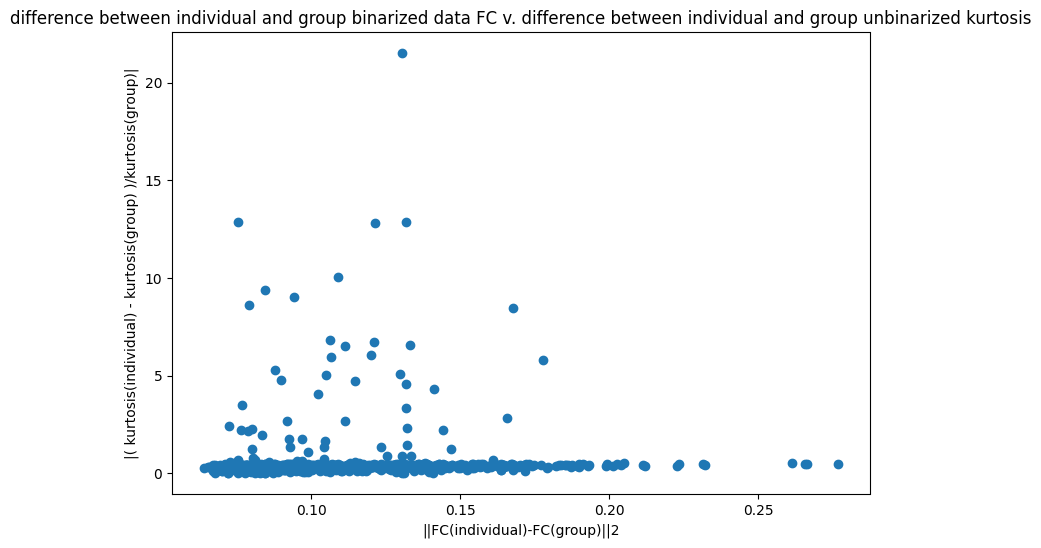

In [37]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.scatter( depytorch(fc_rmse_from_group), depytorch(data_ts_diff_from_kurtosis) )
axs.set_xlabel('||FC(individual)-FC(group)||2')
axs.set_ylabel('|( kurtosis(individual) - kurtosis(group) )/kurtosis(group)|')
axs.set_title('difference between individual and group binarized data FC v. difference between individual and group unbinarized kurtosis')
fc_std_diff_corr = isingmodellight.get_pairwise_correlation(mat1=fc_rmse_from_group, mat2=data_ts_diff_from_kurtosis, epsilon=0, dim=0)
print(f'correlation between difference in binarized FC RMSE and difference in original kurtosis {fc_std_diff_corr:.3g}')